# Phrase Quest

This analysis is intended as a step toward an application called Phrase Quest. Phrase Quest is a game to associate phrases with places to create a geographic road tour map out of these associations. The hope is to create a snapshot of a road tour out of phrases, colloquialisms, key words in scientific fields, inside jokes, or song lyrics. 


In the technical details, the application will map discrete data in four dimensions to real data in two dimensions. While this is a broadly applicable technical task, I am applying it the specific problem of creating a simplistic secret code based on airport name data and latitudes and longitudes from OpenFlights.org. I have explored using Twitter data but do not currently have a Twitter developer's licence.  . 

In [20]:
#!/usr/bin/python
import os, sys, random

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.stats import cauchy
import numpy as np
from io import StringIO
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LinearRegression



I begin by defining some functions that will be used later. These have to do with the scaling of the linguistic data and the processing of the text.

In [21]:


def powerlaw(x,a,b,c):
    return a*x**b+c

def f5(x,a,b,c,d,g,h):
    return a*x**5+b*x**4+c*x**3+d*x**2+g*x+h

def f3(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

def VowelToConsRatio(name):
    
    words = sum(c.isalpha() for c in name)
    spaces = sum(c.isspace() for c in name)
    others = len(name) - words - spaces
    vowels = sum(map(name.lower().count, "aeiou"))
    consonents = words - vowels


    return float(vowels)/float(consonents), float(spaces)/float(consonents), float(others)/float(consonents)



def AirportNameLetterFrequency(name):
    
    words = sum(c.isalpha() for c in name)
    spaces = sum(c.isspace() for c in name)
    others = len(name) - words - spaces
    vowels = sum(map(name.lower().count, "aeiou"))
    consonents = words - vowels
    #put a one at the end to account for one airport in number totaled. will be normalized later

    return [consonents, vowels, spaces, others, 1]


def MergeCount(totalCount, thisCount):
    totalCount2=totalCount+thisCount
    return totalCount2


def transformphrase(testphrases,poly,clf):
    xphrases=[]
    for phrase in testphrases:
        print(phrase)
        vtc, stc, otc = VowelToConsRatio(phrase)
        xphrases.append([vtc,stc,otc])
    scaler=StandardScaler()
    xphrases2=scaler.fit_transform(xphrases)
    Poly_phrases=poly.fit_transform(xphrases2)
    Y_latlon=clf.predict(Poly_phrases)
    return Y_latlon



def LatLongClassMaker(coor):
    lat,long=coor
    if lat<30:
        if long>-90:
            return 1 #florida
        elif long < -120:
            return 2 #hawaii
        else:
            return 3 #texas
    elif lat >50:
        return 4 #alaska
    elif long> -80 and lat < 40:
        return 5 #south east
    elif long> -80 and lat >40:
        return 6 #new england
    elif long< -80:
        return int((50-lat)/20.*5)*int((125+long)/45.*9)+7
    else:
        return 0
    #worst mapping ever-- ignores new england and city diversity
    return 0







This data contains airports, train stops, and bus terminals throughout the world supplied by users. 

In [22]:
file = open("airports-extended.dat.txt","r")

# Histograms of scaling of language data

In [23]:
totalUSAcount=np.zeros(5)
totalChinacount=np.zeros(5)
totalEnglandcount=np.zeros(5)
totalFrancecount=np.zeros(5)
totalGermanycount=np.zeros(5)
totalMexicocount=np.zeros(5)
totalCanadacount=np.zeros(5)



#I picked some countries I have familiarity with so I know whether or not the data makes sense when I see it, sort of.

#what I want is the histogram of counts within each country to compare distributions between countries by eye. I can then look at a regression within the US by longitude and lattitude (actual distance from Chicago?) if it looks interesting

Chinavowel=[]
Chinacons=[]
USvowel=[]
UScons=[]
Englandvowel=[]
Englandcons=[]
Francevowel=[]
Francecons=[]
Germanyvowel=[]
Germanycons=[]
Mexicovowel=[]
Mexicocons=[]
Canadavowel=[]
Canadacons=[]

for line in file:
    line=re.split(',',line);
    if line[3] == "\"China\"":
        thisChinacount = AirportNameLetterFrequency(line[1])
        Chinavowel.append(thisChinacount[1])
        Chinacons.append(thisChinacount[0])
    if line[3] == "\"United States\"":
        thisUSAcount = AirportNameLetterFrequency(line[1])
        USvowel.append(thisUSAcount[1])
        UScons.append(thisUSAcount[0])
    
    if line[3] == "\"United Kingdom\"":
        thisEnglandcount = AirportNameLetterFrequency(line[1])
        Englandvowel.append(thisEnglandcount[1])
        Englandcons.append(thisEnglandcount[0])
    
    if line[3] == "\"France\"":
        thisFrancecount = AirportNameLetterFrequency(line[1])
        Francevowel.append(thisFrancecount[1])
        Francecons.append(thisFrancecount[0])
    
    if line[3] == "\"Germany\"":
        thisGermanycount = AirportNameLetterFrequency(line[1])
        Germanyvowel.append(thisGermanycount[1])
        Germanycons.append(thisGermanycount[0])
    
    if line[3] == "\"Mexico\"" :
        thisMexicocount = AirportNameLetterFrequency(line[1])
        Mexicovowel.append(thisMexicocount[1])
        Mexicocons.append(thisMexicocount[0])
    if line[3] == "\"Canada\"" :
        thisCanadacount = AirportNameLetterFrequency(line[1])
        Canadavowel.append(thisCanadacount[1])
        Canadacons.append(thisCanadacount[0])
        
                

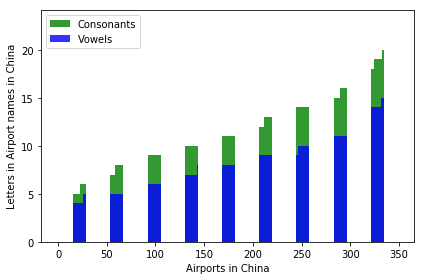

In [24]:
fig, ax = plt.subplots()
n_groups=len(Chinavowel)
index=np.arange(n_groups)
bar_width=0.35
opacity = 0.8
rects2 = plt.bar(index, np.sort(np.asarray(Chinacons)), bar_width, alpha=opacity, color='g', label='Consonants')
rects1 = plt.bar(index, np.sort(np.asarray(Chinavowel)), bar_width, alpha=opacity, color='b', label='Vowels')


plt.xlabel('Airports in China')
plt.ylabel('Letters in Airport names in China')
plt.legend()

plt.tight_layout()
plt.show()

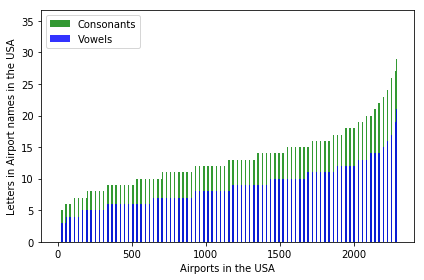

In [25]:
fig, ax = plt.subplots()
n_groups=len(USvowel)
index=np.arange(n_groups)
bar_width=0.35
opacity = 0.8
rects2 = plt.bar(index, np.sort(np.asarray(UScons)), bar_width, alpha=opacity, color='g', label='Consonants')
rects1 = plt.bar(index, np.sort(np.asarray(USvowel)), bar_width, alpha=opacity, color='b', label='Vowels')


plt.xlabel('Airports in the USA')
plt.ylabel('Letters in Airport names in the USA')
plt.legend()

plt.tight_layout()
plt.show()

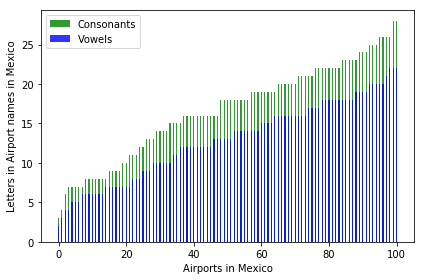

In [26]:
fig, ax = plt.subplots()
n_groups=len(Mexicovowel)
index=np.arange(n_groups)
bar_width=0.35
opacity = 0.8
rects2 = plt.bar(index, np.sort(np.asarray(Mexicocons)), bar_width, alpha=opacity, color='g', label='Consonants')
rects1 = plt.bar(index, np.sort(np.asarray(Mexicovowel)), bar_width, alpha=opacity, color='b', label='Vowels')


plt.xlabel('Airports in Mexico')
plt.ylabel('Letters in Airport names in Mexico')
plt.legend()

plt.tight_layout()
plt.show()

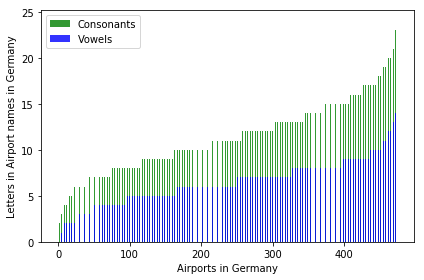

In [27]:
fig, ax = plt.subplots()
n_groups=len(Germanyvowel)
index=np.arange(n_groups)
bar_width=0.35
opacity = 0.8
rects2 = plt.bar(index, np.sort(np.asarray(Germanycons)), bar_width, alpha=opacity, color='g', label='Consonants')
rects1 = plt.bar(index, np.sort(np.asarray(Germanyvowel)), bar_width, alpha=opacity, color='b', label='Vowels')


plt.xlabel('Airports in Germany')
plt.ylabel('Letters in Airport names in Germany')
plt.legend()

plt.tight_layout()
plt.show()

# Making discrete data continuous

I use a standard technique in machine learning to make discrete data continuous. I take a ratio of two discrete quantities, in particular the consonant symbol count forms the denomonator. Rehistogramming, I seek to find a fit to the shape of the scaling so that I may transform the data for a regression.

In [40]:
file = open("airports-extended.dat.txt","r")
totalUSAcount=np.zeros(5)
totalChinacount=np.zeros(5)
totalEnglandcount=np.zeros(5)
totalFrancecount=np.zeros(5)
totalGermanycount=np.zeros(5)
totalMexicocount=np.zeros(5)
totalCanadacount=np.zeros(5)



#I picked some countries I have familiarity with so I know whether or not the data makes sense when I see it, sort of.

#what I want is the histogram of counts within each country to compare distributions between countries by eye. I can then look at a regression within the US by longitude and lattitude (actual distance from Chicago?) if it looks interesting


Chinaratio=[]
USAratio=[]
Englandratio=[]
Germanyratio=[]
Franceratio=[]
Canadaratio=[]
Mexicoratio=[]

for line in file:
    line=re.split(',',line);
#    if line[3] == "\"China\"":
#        thisChinaratio = VowelToConsRatio(line[1])
#        Chinaratio.append(thisChinaratio)
    if line[3] == "\"United States\"":
        thisUSAratio = VowelToConsRatio(line[1])
        USAratio.append(thisUSAratio)
    if line[3] == "\"United Kingdom\"":
        thisEnglandratio = VowelToConsRatio(line[1])
        Englandratio.append(thisEnglandratio)
    
    if line[3] == "\"France\"":
        thisFranceratio = VowelToConsRatio(line[1])
        Franceratio.append(thisFranceratio)
    
    
    if line[3] == "\"Germany\"":#
        thisGermanyratio = VowelToConsRatio(line[1])
        Germanyratio.append(thisGermanyratio)
    
    if line[3] == "\"Mexico\"" :
        thisMexicoratio = VowelToConsRatio(line[1])
        Mexicoratio.append(thisMexicoratio)
    if line[3] == "\"Canada\"" :
        thisCanadaratio = VowelToConsRatio(line[1])
        Canadaratio.append(thisCanadaratio)
        
                
Canadaarr=np.asarray(Canadaratio)
Canadaarr.sort()
USAarr=np.asarray(USAratio)
USAarr.sort()
UKarr=np.asarray(Englandratio)
UKarr.sort()
Francearr=np.asarray(Franceratio)
Francearr.sort()
Germanyarr=np.asarray(Germanyratio)
Germanyarr.sort()
Mexicoarr=np.asarray(Mexicoratio)
Mexicoarr.sort()


In [49]:
np.shape(USAarr)

(2294, 3)

In [53]:
from bokeh.plotting import figure, output_notebook, show

n_groups=len(USAratio)
p = figure(plot_width=400, plot_height=400, title="Vowels/Consonants ratio, sorted", x_axis_label="Airports in the USA", y_axis_label="Letter ratio in Airport names in the USA")
p.vbar(x=index, width=0.5, bottom=0, top=np.sort(USAarr[:,0]), color='blue')

show(p)

Fit power law to reversed histogram

In [60]:
xdat=np.arange(len(USAarr))
ydat0=np.sort(USAarr[:,0])
ydat=ydat0[::-1]
par=[1.,1.,1.,1.]
p0=par
par,pvar=curve_fit(powerlaw,xdat,ydat)


In [61]:
p=figure(height=400,width=400,title="Power law fit to v/c histogram", x_axis_label="v/c", y_axis_label="ratio of counts")
p.vbar(x=index, width=0.5, bottom=0, top=ydat, color='cyan', legend='v/c data')
p.line(index, powerlaw(index,par[0],par[1],par[2]),color='black', legend='power law fit')
output_notebook()
show(p)

Loading BokehJS ...

Fit third order polynomial to histogram.

In [62]:
xdat=np.arange(len(USAarr))
ydat0=np.sort(USAarr[:,0])
ydat=ydat0[::-1]
par=[1.,1.,1.,1.]
p0=par
par,pvar=curve_fit(f3,xdat,ydat)




In [64]:
p=figure(height=400,width=400,title="Third order polynomial fit to v/c histogram", x_axis_label="v/c", y_axis_label="ratio of counts")
p.vbar(x=index, width=0.5, bottom=0, top=ydat, color='cyan', legend='v/c data')
p.line(index, f3(index,par[0],par[1],par[2],par[3]),color='black', legend='Third order polynomial fit')
output_notebook()
show(p)

Loading BokehJS ...

It looks like it's a blend of third order polynomial and power law. Probably the best fit could be achieved by matching the two in some buffer region by matching the derivatives smoothly at the inflection point. I have not yet tried this. To preliminarily investigate, I used a third order power law.

# Polynomial transformation and linear regression

To produce a map of phrases to places, I performed a polynomial transformation and linear regression in multiple dimensions using the scikit-learn toolkit in python.

In [66]:
file = open("airports-extended.dat.txt","r")
ratio=[]
coords=[]


for line in file:
    line=re.split(',',line);

    if line[3] == "\"United States\"":
        thisratioV, thisratioS, thisratioO=VowelToConsRatio(line[1]);
        ratio.append([thisratioV,thisratioS,thisratioO])
        coords.append([float(line[6]),float(line[7])])


ratioarray=np.empty([len(ratio),3])
coordsarray=np.empty([len(coords),2])
regionarray=np.empty([len(coords)])

for i, rat in enumerate(ratio):
    ratioarray[i,:]=rat
for i,coor in enumerate(coords):
    coordsarray[i,:]=coor
#    outputcoor=LatLongClassMaker(coor)
#    regionarray[i]=outputcoor

xtrain,xtest,ytrain,ytest=train_test_split(ratioarray,coordsarray,test_size=0.33,shuffle=True, random_state=random.randint(1,101))

These test phrases are phrases I gathered from myself, my sister who lives abroad, my parents, and the chair of my masters exam committee from Louisiana State University who works in Loop Quantum Gravity. I wrote both a fairly broad selection of phrases and a set of songs. My sister used inside jokes. My father used songs. My mother used colloquialisms. My committee chair used key words from the field in the word cloud I harvested.

In [67]:
testphrases=["Ufda!", "I just dont know about that", "Howdy, pardner", "Where are we?", 
             "I thank whatever gods may be for my unconquerable soul.", "I welcome our new robot overlords",
             "l33t h4k3rs", "I know you I walked with you once upon a dream", 
             "These stories dont mean anything if you have no one to tell them to", 
             "Baby you have the sort of hands that rip me apart","Multi-messenger astronomy", 
             "Rainbow flag", "I prefer They or He?", "numerical relativity", "LIGO", "scalar field", 
             "Osculating Orbits", "Monte-Carlo Simulation", "Data Analysis", "Data Science", "Parallelization", 
             "Paralyzation", "Partial disability", "Non-epileptic seizures", "Wednesday Lunch", "Tuesday Lunch", 
             "Thursday Lunch", "Guild Wars", "Elvenar", "Good Apple"]

colleaguephrases=["general relativity", "black hole", "loop quantum gravity",  "quantization", "space-time", 
                  "Hamiltonian constraint", "Ashtekar", "LiSA", "LIGO", "group", "white hole", "scalar field",
                  "numerical relativity", "cosmology", "diffeomorphism", "continuum limit", "David Berger", 
                  "Reisner-Nordstrom", "black hole spacetime", "initial data", "interpretation of quantum mechanics"]


mysongs=["My gift is your song and this one’s for you.",
"I closed my eyes, drew back the curtain, to see for certain, what I thought I knew.",
"Mamma if you don’t mind my sayin so you have a bad habit of changing every subject. No I didn’t change the subject.",
"I did not live until today, how can I live when we are parted? One day more.",
"Pick a little talk a little pick a little talk a little cheep cheep cheep talk a lot pick a little more…",
"I’ll be your queen, and you’ll be my castle.",
"She’s wicked so we’ve got to bring her down. ",
"And all this science I don’t understand. It’s just my job five days a week.",
"A life time of not knowing where or how or why or when.",
"Mathematics isolation rhythm feeling power harmony and heavy competition.",
"I’m through playing by the rules of someone else’s game. Too late for second guesses too late to go back to sleep. It’s time to trust my instincts close my eyes and leap. It’s time to try defying gravity and you can’t pull me down.",
"Maybe far away, or maybe real nearby… ",
"SO IF YOU CARE TO FIND ME LOOK TO THE WESTERN SKY AS SOMEONE TOLD ME LATELY EVERYONE DESERVES A CHANCE TO FLY and if I’m flying solo at least I’m flying free to those who ground me take a lesson back from me. ",
"I’m sorry for everything I said and for everything I forgot to say too…"]

dadssongs=["1. Mars ain't no place to raise a kid. Besides it’s cold as hell",
"2. she’ll have fun, fun, fun till her daddy takes her T bird away",
"3. A man hears what he wants to hear, and disregards the rest",
"4. All revved up and no place to go",
"5. Why they changed it, I can’t say…people just liked it better that way",
"6. First you take a step to the left, then you jump to the right",
"7. Young man!!",
"8. And while I’m away, I’ll write home every day..and send all my lov’in to you",
"9. Each night before you go to bed, my baby, whisper a little prayer for me, my baby",
"10. Master of the house, keeper of the zoo",
"11. May you be forever young",
"12. Weave me the sunshine"]

momphrases=["I just don’t know about that.",
"Well that’s different.",
"Way to go!",
"That’s awesome!",
"In a little while…",
"Go to bed!",
"It’ll all work out."
"Sooner or later",
"Clean your room!",
"The one with the most fabric wins.",
"I’m off to sew!",
"It’s a great day!",
"How can I help?",
"Time to eat!",
"Read your book.",
"Are you ready?",
"I’m sure."]

sisterphrases=["1. Running down the dream", "2. How much is a gallon?", "3. Dead snake on a lake", 
               "4. Pseudaphed and tumbleweeds", "5. East Jesus Nowhere", "6. Taxation without representation", 
               "7. Old people, high schoolers and drug dealers", "8. it was a trial for... MURDER!", 
               "9. Rock lobster", "10. Trapeze hands", "11. Hinga Weezy", "12. Patty dance pants"]

 



In [68]:

xphrases=[]
for phrase in testphrases:
    print(phrase)
    vtc, stc, otc = VowelToConsRatio(phrase)
    xphrases.append([vtc,stc,otc])
xcolleague=[]
for phrase in colleaguephrases:
    print(phrase)
    vtc, stc, otc = VowelToConsRatio(phrase)
    xcolleague.append([vtc,stc,otc])



Ufda!
I just dont know about that
Howdy, pardner
Where are we?
I thank whatever gods may be for my unconquerable soul.
I welcome our new robot overlords
l33t h4k3rs
I know you I walked with you once upon a dream
These stories dont mean anything if you have no one to tell them to
Baby you have the sort of hands that rip me apart
Multi-messenger astronomy
Rainbow flag
I prefer They or He?
numerical relativity
LIGO
scalar field
Osculating Orbits
Monte-Carlo Simulation
Data Analysis
Data Science
Parallelization
Paralyzation
Partial disability
Non-epileptic seizures
Wednesday Lunch
Tuesday Lunch
Thursday Lunch
Guild Wars
Elvenar
Good Apple
general relativity
black hole
loop quantum gravity
quantization
space-time
Hamiltonian constraint
Ashtekar
LiSA
LIGO
group
white hole
scalar field
numerical relativity
cosmology
diffeomorphism
continuum limit
David Berger
Reisner-Nordstrom
black hole spacetime
initial data
interpretation of quantum mechanics


In [69]:
scaler = StandardScaler()
xtrain2=scaler.fit_transform(xtrain)
xtest2=scaler.fit_transform(xtest)
xphrases2=scaler.fit_transform(xphrases)
#xcolleague2=scaler.fit_transform(xcolleague)


In [7]:
poly=PolynomialFeatures(3)
Poly_test=poly.fit_transform(xtest)
Poly_train=poly.fit_transform(xtrain)
Poly_phrases=poly.fit_transform(xphrases)
#X_kpca_colleague=kpca.fit_transform(xcolleague2)

print(Poly_phrases[0])
print(Poly_train[0])
#print(X_kpca_colleague[0])

print(np.shape(Poly_train))
print(np.shape(ytrain))







[1.    1.    0.    0.5   1.    0.    0.5   0.    0.    0.25  1.    0.
 0.5   0.    0.    0.25  0.    0.    0.    0.125]
[1.         0.47058824 0.17647059 0.11764706 0.22145329 0.08304498
 0.05536332 0.03114187 0.02076125 0.01384083 0.10421331 0.03907999
 0.02605333 0.014655   0.00977    0.00651333 0.00549562 0.00366375
 0.0024425  0.00162833]
(1536, 20)
(1536, 2)


In [78]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

In [79]:
from sklearn.linear_model import Ridge
clf=Ridge(alpha=.001)

In [80]:
clf.fit(Poly_train,ytrain)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [81]:
latlongpred=clf.predict(Poly_test)

This figure shows that the validation set does not entirely reproduce the training set. There is a scale factor mismatch, and Alaska is missing. This is suspicious since both were produced through the same procedure (albeit without refitting the polynomial transformation or the ridge regression the second time). This is most likely due to the tail of the distribution where the polynomial form becomes a power law form. It would be a good idea to account for that by hand. 

In [77]:
p=figure(plot_width=600, plot_height=600, title="Training and Verification Data", x_axis_label="Longitude", y_axis_label="Latitude")
p.square(ytrain[:,1], ytrain[:,0], color="blue", legend="Coordinates of airport in training set")
p.circle(ytest[:,1],ytest[:,0],color="yellow", legend="Coordinates of airports in test set")
p.x(latlongpred[:,1],latlongpred[:,0], color="red", legend="Mappings of airport nanes to positions")
output_notebook()
show(p)

Loading BokehJS ...

# Splicing a power law and a polynomial

In [99]:
from scipy.optimize import minimize

def powerlaw(x,a,b,c):
    return a*x**b+c

def f5(x,a,b,c,d,g,h):
    return a*x**5+b*x**4+c*x**3+d*x**2+g*x+h

def f3(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

def polypowerboundaryconstraint(x,a1,b1,c1,a2,b2,c2):
    def polypowerlawboundarysolve(x): 
        return a1*b1*x**(b1-1)-(a2*3*x**2+b2*2*x+c2)
    return polypowerlawboundarysolve





def polypower(x,a1,b1,c1,a2,b2,c2,d2):
        #boundary constraint
        polypowerlawboundarysolver=polypowerboundaryconstraint(x,a1,b1,c1,a2,b2,c2)
        boundaryx=minimize(polypowerlawboundarysolver,x0=1000) #hard coded to be half of len(xdat)
        if(x>boundaryx):
            return f3(x,a2,b2,c2,d2)
        else:
            return powerlaw(x,a1,b1,c1)

The boundary constraint is not completely trivial in closed form, so it is best solved numerically using minimization. The boundary condition is set by making the derivative smooth. 

In [86]:
file = open("airports-extended.dat.txt","r")
totalUSAcount=np.zeros(5)
totalChinacount=np.zeros(5)
totalEnglandcount=np.zeros(5)
totalFrancecount=np.zeros(5)
totalGermanycount=np.zeros(5)
totalMexicocount=np.zeros(5)
totalCanadacount=np.zeros(5)



#I picked some countries I have familiarity with so I know whether or not the data makes sense when I see it, sort of.

#what I want is the histogram of counts within each country to compare distributions between countries by eye. I can then look at a regression within the US by longitude and lattitude (actual distance from Chicago?) if it looks interesting


Chinaratio=[]
USAratio=[]
Englandratio=[]
Germanyratio=[]
Franceratio=[]
Canadaratio=[]
Mexicoratio=[]

for line in file:
    line=re.split(',',line);
#    if line[3] == "\"China\"":
#        thisChinaratio = VowelToConsRatio(line[1])
#        Chinaratio.append(thisChinaratio)
    if line[3] == "\"United States\"":
        thisUSAratio = VowelToConsRatio(line[1])
        USAratio.append(thisUSAratio)
    if line[3] == "\"United Kingdom\"":
        thisEnglandratio = VowelToConsRatio(line[1])
        Englandratio.append(thisEnglandratio)
    
    if line[3] == "\"France\"":
        thisFranceratio = VowelToConsRatio(line[1])
        Franceratio.append(thisFranceratio)
    
    
    if line[3] == "\"Germany\"":#
        thisGermanyratio = VowelToConsRatio(line[1])
        Germanyratio.append(thisGermanyratio)
    
    if line[3] == "\"Mexico\"" :
        thisMexicoratio = VowelToConsRatio(line[1])
        Mexicoratio.append(thisMexicoratio)
    if line[3] == "\"Canada\"" :
        thisCanadaratio = VowelToConsRatio(line[1])
        Canadaratio.append(thisCanadaratio)
        
                
Canadaarr=np.asarray(Canadaratio)
Canadaarr.sort()
USAarr=np.asarray(USAratio)
USAarr.sort()
UKarr=np.asarray(Englandratio)
UKarr.sort()
Francearr=np.asarray(Franceratio)
Francearr.sort()
Germanyarr=np.asarray(Germanyratio)
Germanyarr.sort()
Mexicoarr=np.asarray(Mexicoratio)
Mexicoarr.sort()


In [100]:
from scipy.optimize import least_squares
xdat=np.arange(len(USAarr))
ydat0=np.sort(USAarr[:,0])
ydat=ydat0[::-1]
pmine=[5.,-3.,0.5,1.,1.,1.,0.5]


In [98]:
len(xdat)/2

1147.0

In [101]:
par,pvar=curve_fit(polypower,xdat,ydat,p0=pmine)

TypeError: '>' not supported between instances of 'int' and 'OptimizeResult'